In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [ ]:
#file loads:
filepath = r"C:\Users\20202917\Downloads\nv1fehuuii7o8hjb.csv"
#ik gebruik nu web loads voor ff3 en momentum wellicht beter om die te downloaden en op de hub te zetten
ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
mom_data = web.DataReader('F-F_Momentum_Factor', 'famafrench', start='1985', end='2025')[0]

## Part 3: Measuring Geopolitical News

We measure geopolitical risk using the monthly Geopolitical Risk Index (GPR) constructed by Caldara and Iacoviello (2022), which captures geopolitical tensions through newspaper text analysis. The index is publicly available at  
https://www.policyuncertainty.com/gpr.html.

To isolate unexpected updates in geopolitical risk, we construct a shock series from the raw index. Specifically, we model GPR using an AR(1) process and define the geopolitical news shock as the one-step-ahead forecast error:

$$
GPR\_Shock_t = GPR_t - \hat{GPR}_t
$$

where $\hat{GPR}_t$ is the predicted value from the AR(1) model, following the innovation-extraction approach in Engle et al. (2020).


In [4]:

# data cleaning things..
raw = pd.read_excel("data_gpr_export.xls")
df = raw[["month", "GPR"]].copy()
df["month"] = pd.to_datetime(df["month"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["month", "GPR"]).sort_values("month").reset_index(drop=True)

# Make month the index 
df = df.set_index("month")
# definition simple difference shock: GPR_t - GPR_{t-1}
# here I just include a simple difference, to compare the AR to something
df["gpr_change"] = df["GPR"].diff()

# 2) AR(1): GPR_t = c + phi * GPR_{t-1} + u_t
gpr = df["GPR"]
gpr_lag = gpr.shift(1)

df["gpr_ar1_pred"] = np.nan
df["gpr_news_shock"] = np.nan


# Start once we have enough data to estimate, for the AR(1)
# Keep in mind we do not want to use future data to hedge ofc,
# Do we then use an expanding or moving window? Feel free to leave suggestions, gang
min_obs = 24 

for i in range(min_obs, len(df)):
    # Use data up to t-1 to fit AR(1)
    y_train = gpr.iloc[1:i]              
    x_train = gpr_lag.iloc[1:i]          
    train = pd.concat([y_train, x_train], axis=1).dropna()

    y = train.iloc[:, 0]
    x = sm.add_constant(train.iloc[:, 1])

    model = sm.OLS(y, x).fit()

    # One-step-ahead prediction for time t
    x_t = sm.add_constant(pd.Series([gpr_lag.iloc[i]], index=["x"]), has_constant="add")
    # Align names to model params
    x_t = pd.DataFrame({"const": [1.0], train.columns[1]: [gpr_lag.iloc[i]]})

    gpr_hat_t = float(model.predict(x_t)[0])
    shock_t = float(gpr.iloc[i] - gpr_hat_t)

    df.iloc[i, df.columns.get_loc("gpr_ar1_pred")] = gpr_hat_t
    df.iloc[i, df.columns.get_loc("gpr_news_shock")] = shock_t

# Standardize shocks (z-scores)
df["gpr_change_z"] = (df["gpr_change"] - df["gpr_change"].mean()) / df["gpr_change"].std()
df["gpr_news_shock_z"] = (df["gpr_news_shock"] - df["gpr_news_shock"].mean()) / df["gpr_news_shock"].std()

# columns:
# gpr_news_shock   : AR(1) innovation in GPR (raw)
# gpr_news_shock_z : standardized AR(1) GPR shock
# gpr_change      : month-to-month change in GPR
# gpr_change_z    : standardized change in GPR
df


,GPR,gpr_change,gpr_ar1_pred,gpr_news_shock,gpr_change_z,gpr_news_shock_z
month,,,,,,
1985-01-01,102.173378,NaN,NaN,NaN,NaN,NaN
1985-02-01,117.102020,14.928642,NaN,NaN,0.420577,NaN
1985-03-01,124.778152,7.676132,NaN,NaN,0.215553,NaN
1985-04-01,87.929001,-36.849152,NaN,NaN,-1.043155,NaN
1985-05-01,103.262848,15.333847,NaN,NaN,0.432032,NaN
...,...,...,...,...,...,...
2025-08-01,136.759415,1.755157,126.131691,10.627724,0.048170,0.321744
2025-09-01,124.114983,-12.644432,127.436132,-3.321149,-0.358899,-0.084686
2025-10-01,154.425201,30.310219,118.259686,36.165515,0.855407,1.065841


# Part 2: Constructing a Hedge Portfolio

In [6]:
df_stocks = pd.read_csv(filepath)
df_stocks.columns = df_stocks.columns.str.lower()

df_stocks['ret'] = pd.to_numeric(df_stocks['ret'], errors='coerce')
df_stocks = df_stocks.dropna(subset=['ret', 'date', 'permno'])
df_stocks.head()

C:\Users\20202917\AppData\Local\Temp\ipykernel_15320\1019025301.py:1: DtypeWarning: Columns (5,6,9,18,19,49,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stocks = pd.read_csv(filepath)


,permno,date,nameendt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,...,cfacshr,altprc,spread,altprcdt,retx,vwretd,vwretx,ewretd,ewretx,sprtrn
2,10000,1986-02-28,NaN,10.0,3.0,3990.0,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-3.25000,0.25000,1986-02-28,-0.257143,0.072501,0.068191,0.060381,0.058938,0.071489
3,10000,1986-03-31,NaN,10.0,3.0,3990.0,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.43750,0.12500,1986-03-31,0.365385,0.053887,0.051362,0.047192,0.045679,0.052794
4,10000,1986-04-30,NaN,10.0,3.0,3990.0,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.00000,0.25000,1986-04-30,-0.098592,-0.007903,-0.009634,0.016140,0.015141,-0.014148
5,10000,1986-05-30,NaN,10.0,3.0,3990.0,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-3.10938,0.09375,1986-05-30,-0.222656,0.050847,0.047126,0.036194,0.034779,0.050229
6,10000,1986-06-30,NaN,10.0,3.0,3990.0,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-3.09375,0.06250,1986-06-30,-0.005025,0.014244,0.011622,0.008087,0.006715,0.014110


In [ ]:

ff3 = ff3.reset_index().rename(columns={'Date': 'date'})
ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] = ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100.0
ff3['date'] = ff3['date'].dt.to_timestamp(freq='M') + MonthEnd(0)


mom_data = mom_data.reset_index().rename(columns={'Date': 'date'})
mom_data[['Mom']] = mom_data[['Mom']] / 100.0 # Convert to decimal
mom_data['date'] = mom_data['date'].dt.to_timestamp(freq='M') + MonthEnd(0)

factors = ff3.merge(mom_data, on='date', how='inner')
factors.head()

C:\Users\20202917\AppData\Local\Temp\ipykernel_15320\2001561061.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
C:\Users\20202917\AppData\Local\Temp\ipykernel_15320\2001561061.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
C:\Users\20202917\AppData\Local\Temp\ipykernel_15320\2001561061.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  m

,date,Mkt-RF,SMB,HML,RF,Mom
0,1985-01-31,0.0797,0.0328,-0.0520,0.0065,-0.0682
1,1985-02-28,0.0122,0.0063,-0.0036,0.0058,0.0190
2,1985-03-31,-0.0083,-0.0107,0.0401,0.0062,0.0178
3,1985-04-30,-0.0096,0.0009,0.0360,0.0072,0.0295
4,1985-05-31,0.0507,-0.0230,-0.0098,0.0066,0.0405


In [18]:
#making everything date! to merge on
df_stocks['date'] = pd.to_datetime(df_stocks['date'], errors='coerce')
factors['date'] = pd.to_datetime(factors['date'], errors='coerce')
df_gpr_clean = df.reset_index().rename(columns={'month': 'date'})
df_gpr_clean['date'] = pd.to_datetime(df_gpr_clean['date'], errors='coerce')

#Ensure all are aligned ath the end of the month
df_stocks['date'] = df_stocks['date'] + MonthEnd(0)
factors['date'] = factors['date'] + MonthEnd(0)
df_gpr_clean['date'] = df_gpr_clean['date'] + MonthEnd(0)

#checking because i go insane 
print(f"GPR date type: {df_gpr_clean['date'].dtype}")
print(f"Stocks date type: {df_stocks['date'].dtype}")
print(f"Factors date type: {factors['date'].dtype}")

#merging
df_master = df_stocks.merge(factors, on='date', how='inner')
df_master = df_master.merge(df_gpr_clean[['date', 'gpr_news_shock']], on='date', how='inner')
df_master['excret'] = df_master['ret'] - df_master['RF']

print(df_master[['date', 'permno', 'ret', 'Mkt-RF', 'SMB', 'HML', 'RF', 'Mom', 'gpr_news_shock']])

GPR date type: datetime64[ns]
Stocks date type: datetime64[ns]
Factors date type: datetime64[ns]
              date  permno       ret  Mkt-RF     SMB     HML      RF     Mom  \
0       1986-02-28   10000 -0.257143  0.0714 -0.0057 -0.0063  0.0053  0.0256   
1       1986-03-31   10000  0.365385  0.0491 -0.0054 -0.0039  0.0060  0.0238   
2       1986-04-30   10000 -0.098592 -0.0128  0.0276 -0.0281  0.0052 -0.0035   
3       1986-05-31   10000 -0.222656  0.0462 -0.0136 -0.0014  0.0049  0.0206   
4       1986-06-30   10000 -0.005025  0.0106 -0.0093  0.0120  0.0052  0.0494   
...            ...     ...       ...     ...     ...     ...     ...     ...   
3587359 2024-08-31   93436 -0.077390  0.0160 -0.0349 -0.0110  0.0048  0.0481   
3587360 2024-09-30   93436  0.221942  0.0172 -0.0013 -0.0277  0.0040 -0.0062   
3587361 2024-10-31   93436 -0.045025 -0.0100 -0.0099  0.0086  0.0039  0.0300   
3587362 2024-11-30   93436  0.381469  0.0649  0.0446  0.0015  0.0040  0.0100   
3587363 2024-12-31   93

#### Step 1:

In [20]:
#similar as Sid proposes for gpr I used a rolling window:
def rolling_beta_pipeline(group):
    #If the stock has fewer than 60 months of data, exclude it since it has to little data point to do anything
    if len(group) < 60: 
        return pd.Series(np.nan, index=group.index)
    # Dependent variable Excess Return
    endog = group['excret']
    # Independent are the 4 factors and the shock
    exog = sm.add_constant(group[['Mkt-RF', 'SMB', 'HML', 'Mom', 'gpr_news_shock']])
    
    # use a rolling we start with just a 60 month window
    rols = RollingOLS(endog, exog, window=60, min_nobs=36)
    rres = rols.fit()
    return rres.params['gpr_news_shock']

# Calculate bbeta
df_master['beta_gpr'] = df_master.groupby('permno', group_keys=False).apply(rolling_beta_pipeline)

# Lag Beta -> so trrade at t using info from t-1
df_master['beta_gpr_lag'] = df_master.groupby('permno')['beta_gpr'].shift(1)
df_analysis = df_master.dropna(subset=['beta_gpr_lag']).copy()

C:\Users\20202917\AppData\Local\Temp\ipykernel_15320\1093471088.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_master['beta_gpr'] = df_master.groupby('permno', group_keys=False).apply(rolling_beta_pipeline)


#### Step 2:

In [23]:
# Sort firms into 10 deciles
df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(lambda g: pd.qcut(g['beta_gpr_lag'], 10, labels=False, duplicates='drop'))

# Calculate Portfolio Returns
port_rets = df_analysis.groupby(['date', 'decile'])['ret'].mean().unstack()
port_rets.columns = [f'P{i+1}' for i in range(10)]

# Add Factors back for residualization
port_rets = port_rets.merge(factors.set_index('date'), left_index=True, right_index=True)
port_rets.head()

C:\Users\20202917\AppData\Local\Temp\ipykernel_15320\2186807538.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(lambda g: pd.qcut(g['beta_gpr_lag'], 10, labels=False, duplicates='drop'))


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,Mkt-RF,SMB,HML,RF,Mom
date,,,,,,,,,,,,,,,
1989-02-28,-0.083118,NaN,NaN,NaN,-0.083118,NaN,NaN,NaN,NaN,-0.082000,-0.0223,0.0281,0.0099,0.0061,0.0099
1989-03-31,0.008197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.057143,0.0157,0.0067,0.0047,0.0067,0.0351
1989-04-30,-0.024390,NaN,NaN,NaN,0.021176,NaN,NaN,NaN,NaN,0.084871,0.0435,-0.0067,-0.0148,0.0067,0.0171
1989-05-31,0.030853,0.030853,NaN,0.009302,0.006803,NaN,0.006803,NaN,-0.060751,-0.060751,0.0328,-0.0009,-0.0090,0.0079,0.0142
1989-06-30,0.037854,-0.049587,0.07907,-0.061856,0.012683,NaN,0.012683,-0.032847,0.219322,0.003876,-0.0133,-0.0097,0.0221,0.0071,0.0040


#### Step 3:

In [34]:
# Remove months where we don't have all 10 portfolios
# This finds the real start date since from ar(1) we have some start up dates that are nan
port_rets_clean = port_rets.dropna().copy()
print(f"Analysis period: {port_rets_clean.index.min().date()} to {port_rets_clean.index.max().date()}")


# Residualize (Strip 4 Factors from the portfolios)
portfolio_residuals = pd.DataFrame(index=port_rets_clean.index)
resid_cols = []

for i in range(1, 11):
    col = f'P{i}'
    # Regression: Portfolio Return -> Market + Size + Value + Momentum
    Y = port_rets_clean[col] - port_rets_clean['RF']
    X = sm.add_constant(port_rets_clean[['Mkt-RF', 'SMB', 'HML', 'Mom']])
    
    model = sm.OLS(Y, X).fit()
    portfolio_residuals[f'resid_{col}'] = model.resid
    resid_cols.append(f'resid_{col}')

# Estimate Weights (Regress GPR Shock on the Clean Residuals), dont forget to align gpr data with other data
target_shock = df_gpr_clean.set_index('date')['gpr_news_shock'].reindex(portfolio_residuals.index)

# Create a clean dataset for the weights regression
clean_data = pd.concat([target_shock, portfolio_residuals], axis=1).dropna()

Y_shock = clean_data['gpr_news_shock']
X_resids = clean_data[resid_cols]

# The coefficients from this regression are the portfolio weights
weights = sm.OLS(Y_shock, X_resids).fit().params
print(weights)

# Build the geofactor and apply those weights to the ORIGINALreturns
geo_factor_ret = np.zeros(len(port_rets_clean))
for i in range(1, 11):
    w = weights[f'resid_P{i}']
    r = port_rets_clean[f'P{i}']
    geo_factor_ret += w * r

# here i save the results
final_hedge = pd.DataFrame({
    'date': port_rets_clean.index,
    'Hedge_Return': geo_factor_ret,
    'GPR_Shock_News': target_shock
    }).dropna()

print("\nThe hedge portfolio")
final_hedge

Analysis period: 1989-07-31 to 2024-12-31
resid_P1     130.533186
resid_P2      86.584488
resid_P3    -208.606839
resid_P4    -163.556185
resid_P5      27.122740
resid_P6     228.393317
resid_P7       0.852023
resid_P8     205.443427
resid_P9    -124.680201
resid_P10   -117.432981
dtype: float64

The hedge portfolio


,date,Hedge_Return,GPR_Shock_News
date,,,
1989-07-31,1989-07-31,-4.948140,-12.169487
1989-08-31,1989-08-31,5.763184,14.127091
1989-09-30,1989-09-30,11.126851,-17.671565
1989-10-31,1989-10-31,23.795138,-26.081769
1989-11-30,1989-11-30,-7.294675,3.304450
...,...,...,...
2024-08-31,2024-08-31,0.003658,46.092592
2024-09-30,2024-09-30,4.928905,0.195098
2024-10-31,2024-10-31,0.086604,8.212974


#### Visualization

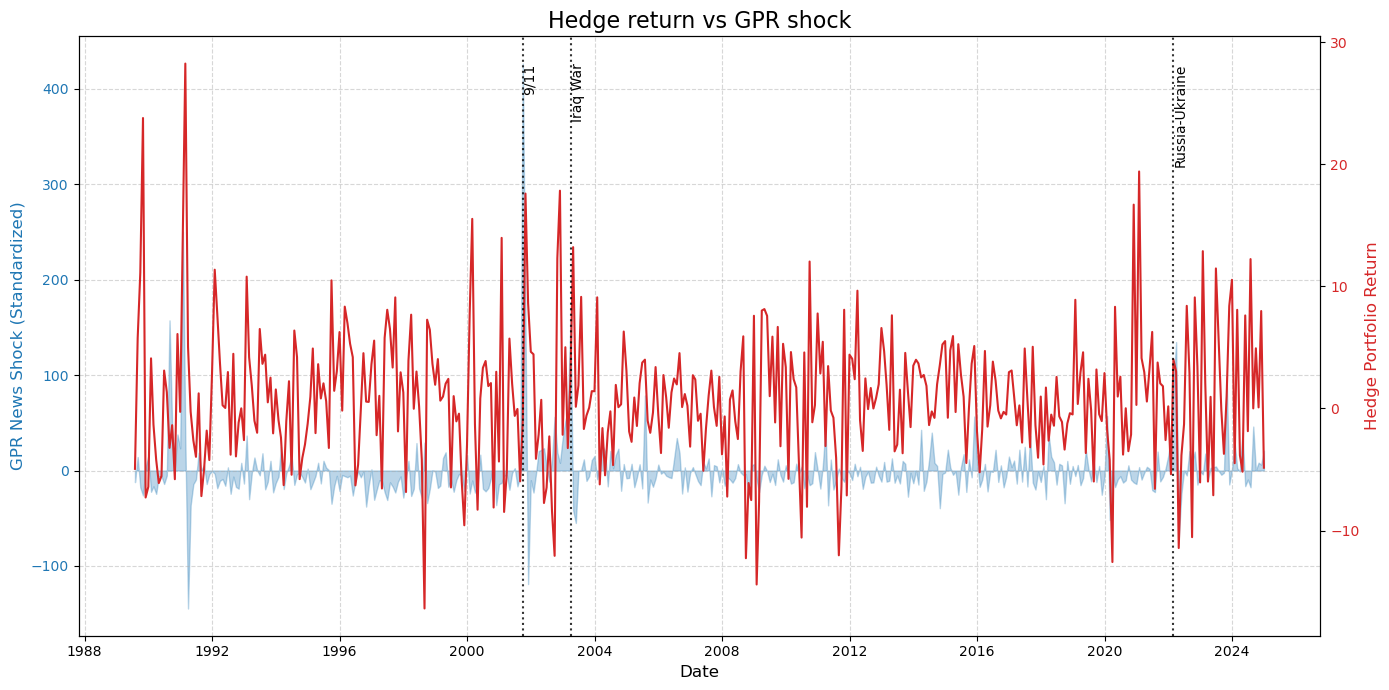

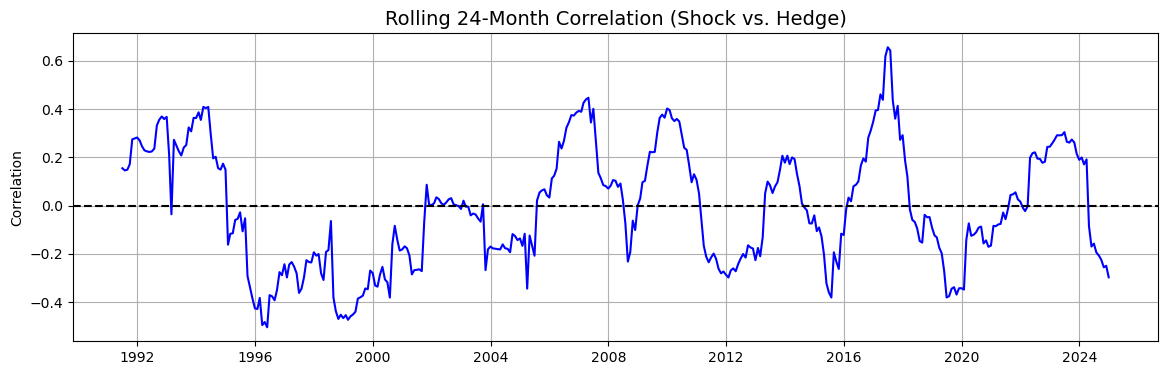

In [39]:
plot_data = final_hedge.set_index('date').copy()

# Create the plot figure
fig, ax1 = plt.subplots(figsize=(14, 7))

# plot The GPR Shock (blue Area),  i use 'fill_between' to show shock clearer
color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('GPR News Shock (Standardized)', color=color, fontsize=12)
ax1.fill_between(plot_data.index, plot_data['GPR_Shock_News'], color=color, alpha=0.3, label='GPR_Shock_News')
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  #second axis for hedge return

# The Hedge Portfolio Return (Red Line)
color = 'tab:red'
ax2.set_ylabel('Hedge Portfolio Return', color=color, fontsize=12)
ax2.plot(plot_data.index, plot_data['Hedge_Return'], color=color, linewidth=1.5, label='Hedge Return')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Hedge return vs GPR shock', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)


#some nead markers to check certain dates
events = {
    pd.Timestamp('2001-09-30'): '9/11',
    pd.Timestamp('2003-03-31'): 'Iraq War',
    pd.Timestamp('2022-02-28'): 'Russia-Ukraine'}

for date, label in events.items():
    if date in plot_data.index:
        plt.axvline(x=date, color='black', linestyle=':', alpha=0.8)
        ax1.text(date, plot_data['GPR_Shock_News'].max(), label, rotation=90, verticalalignment='top')
plt.tight_layout()
plt.show()


# This shows if the hedge is consistently working or only works sometimes
plt.figure(figsize=(14, 4))
rolling_corr = plot_data['Hedge_Return'].rolling(window=24).corr(plot_data['GPR_Shock_News'])
plt.plot(rolling_corr, color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.title('Rolling 24-Month Correlation (Shock vs. Hedge)', fontsize=14)
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

## Part 4: Validation -> We will evaluate whether the geopolitical hedge portfolio:

#### Part 4: Step 1 -> Responds strongly during major geopolitical events (event windows)


In [ ]:
#the events we can check
events = {
    'Gulf War': '1990-08-31',
    '9/11 Attacks': '2001-09-30',
    'Iraq War': '2003-03-31',
    'Arab Spring': '2011-02-28',
    'Crimea Annexation': '2014-03-31',
    'Russia-Ukraine': '2022-02-28',
    'Israel-Hamas': '2023-10-31'
}

results = []


df_study = final_hedge.set_index('date').sort_index()
for name, date_str in events.items():
    event_date = pd.Timestamp(date_str) + pd.offsets.MonthEnd(0)
    if event_date in df_study.index:
        #Get the location (0, 1, 2...) of the date to allow "+2" math
        int_loc = df_study.index.get_loc(event_date)
        #xtract the Shock (using integer location we used above)
        shock_size = df_study.iloc[int_loc]['GPR_Shock_News'] 
        # Calculate 3-Month Cumulative Return (current month + next 2) -> if no 3 months exist drop value
        if int_loc + 3 <= len(df_study):
            # Sum the returns from t, t+1, t+2
            cum_ret = df_study.iloc[int_loc : int_loc+3]['Hedge_Return'].sum()
        else:
            cum_ret = np.nan
        results.append({
            'Event': name,
            'Date': event_date.date(),
            'GPR_Shock': shock_size,
            'Hedge_3Mo_Ret': cum_ret
        })


#the final dataframe with results
event_df = pd.DataFrame(results)
print(event_df)

success_count = event_df[(event_df['GPR_Shock'] > 0) & (event_df['Hedge_3Mo_Ret'] > 0)].shape[0]
print(f"\nSuccess Rate: {success_count}/{len(event_df)} events showed positive hedge returns.")

               Event        Date   GPR_Shock  Hedge_3Mo_Ret
0           Gulf War  1990-08-31  157.361699     -10.398344
1       9/11 Attacks  2001-09-30  426.592896      25.202112
2           Iraq War  2003-03-31  156.292532      15.999543
3        Arab Spring  2011-02-28    4.721905       5.851859
4  Crimea Annexation  2014-03-31   42.682958       7.136894
5     Russia-Ukraine  2022-02-28   88.440407      -4.400102
6       Israel-Hamas  2023-10-31   98.725371      19.947059

Success Rate: 5/7 events showed positive hedge returns.


#### Part 4: Step 2 -> •	Remains stable across sample splits (pre/post 2015 tensions; wartime periods)

In [48]:
cutoff_date = '2015-01-01'

# Split data
pre_2015 = final_hedge[final_hedge['date'] < cutoff_date].copy()
post_2015 = final_hedge[final_hedge['date'] >= cutoff_date].copy()

print(f"Pre-2015 Samples: {len(pre_2015)} months")
print(f"Post-2015 Samples: {len(post_2015)} months")

# regression
def run_stability_reg(df, label):
    # Regression: Hedge_Return = alpha + beta * GPR_Shock
    Y = df['Hedge_Return']
    X = sm.add_constant(df['GPR_Shock_News'])
    
    model = sm.OLS(Y, X).fit()
    
    beta = model.params['GPR_Shock_News']
    t_stat = model.tvalues['GPR_Shock_News']
    p_val = model.pvalues['GPR_Shock_News']
    r_sq = model.rsquared
    
    print(f"\n--- {label} Results ---")
    print(f"Beta (Sensitivity): {beta:.4f}")
    print(f"T-Statistic:        {t_stat:.4f}")
    print(f"P-Value:            {p_val:.4f}")
    print(f"R-Squared:          {r_sq:.4f}")
    
    if p_val < 0.05:
        print("test is significant ")
    else:
        print("test is insignificant")

# run the stability test
run_stability_reg(pre_2015, "PRE-2015 (1990-2014)")
run_stability_reg(post_2015, "POST-2015 (2015-2024)")

Pre-2015 Samples: 306 months
Post-2015 Samples: 120 months

--- PRE-2015 (1990-2014) Results ---
Beta (Sensitivity): 0.0014
T-Statistic:        0.1678
P-Value:            0.8669
R-Squared:          0.0001
test is insignificant

--- POST-2015 (2015-2024) Results ---
Beta (Sensitivity): 0.0083
T-Statistic:        0.4437
P-Value:            0.6581
R-Squared:          0.0017
test is insignificant
